In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

$$\mathrm{d} \textbf{Y}_t = - \mathrm{diag} (\textbf{x}) (\textbf{Y}_t - \textbf{y}_0) \, \mathrm{d}t + b (\textbf{w}^{\top} \textbf{Y}_t) \mathbb{1} \, \mathrm{d}t + \sigma (\textbf{w}^{\top} \textbf{Y}_t) \mathbb{1} \, \mathrm{d} W_t$$


In [3]:
def simulate_batch(Y0, y0, b_func, sigma_func, x, w, N, n, T, num_simulations):
    """
    Simule un processus stochastique avec un terme de dérive locale et globale, ainsi qu'un terme de bruit.

    Parameters
    ----------
    Y0 : numpy.ndarray, shape (num_simulations, N)
        Conditions initiales pour chaque simulation et chaque variable.
    y0 : float or numpy.ndarray, shape (N,)
        Valeur de référence vers laquelle le processus tend localement.
    b_func : callable
        Fonction prenant en entrée un tableau de forme (num_simulations,) (produit scalaire w^T Y)
        et retournant un tableau de même taille, correspondant à la dérive globale.
    sigma_func : callable
        Fonction prenant en entrée un tableau de forme (num_simulations,) (produit scalaire w^T Y)
        et retournant un tableau de même taille, correspondant à la volatilité (écart-type du bruit).
    x : float or numpy.ndarray, shape (N,)
        Coefficient de la dérive locale (force de rappel vers y0).
    w : numpy.ndarray, shape (N,)
        Poids utilisés pour calculer le produit scalaire w^T Y.
    N : int
        Nombre de variables dans le système.
    n : int
        Nombre de pas de temps dans la simulation.
    T : float
        Durée totale de la simulation.
    num_simulations : int
        Nombre de trajectoires simulées en parallèle.

    Returns
    -------
    Y : numpy.ndarray, shape (n, num_simulations, N)
        Tableau contenant les trajectoires simulées à chaque pas de temps, pour chaque simulation et variable.
    """
    dt = T / n
    Y = np.zeros((n, num_simulations, N))
    Y[0] = Y0 
    ones = np.ones((num_simulations, N))

    for i in range(1, n):
        Y_prev = Y[i - 1]

        # w^T * Y : shape (num_simulations,)
        w_dot_Y = np.dot(Y_prev, w)

        # Drift
        drift = - (Y_prev - y0) * x  # shape (num_simulations, N)

        # Global drift
        global_drift = b_func(w_dot_Y).reshape(-1, 1) * ones  # shape (num_simulations, N)

        # Noise
        sigma_vals = sigma_func(w_dot_Y).reshape(-1, 1)
        noise = sigma_vals * np.sqrt(dt) * np.random.randn(num_simulations, 1) * ones

        # Update
        Y[i] = Y_prev + dt * drift + dt * global_drift + noise

    return Y



# Modèle multifacteur à racine carrée

$$\mathrm{d} \textbf{V}_t^N = - \mathrm{diag} (\textbf{x})(\textbf{V}_t^N - v_0) \, \mathrm{d}t + (\theta - \lambda \textbf{w}^{\top}\textbf{V}_t^N) \mathbb{1} \, \mathrm{d}t + \nu \sqrt{\textbf{w}^{\top} \textbf{V}_t^N} \, \mathbb{1} \, \mathrm{d}W_t$$

$$b(x) = \theta - \lambda x, \quad \sigma(x) = \nu \sqrt{x}$$

### Cas $N=2$

In [4]:
N = 2
x = np.array([1, 10])
w = np.array([1, 2])
lam = 0.3
nu = 0.3
V0 = 0.02
theta = 0.02
T = 100
v0 = 0.01*(1/x)
n = 10**5
V_0 = np.array([0,0])

In [6]:
def b(x):
    return theta - lam * x

def sigma(x):
    return nu * np.sqrt(np.maximum(x, 0))

#### Tracer une trajectoire

In [5]:
trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, 1)
V = trajectories[:, 0, :]

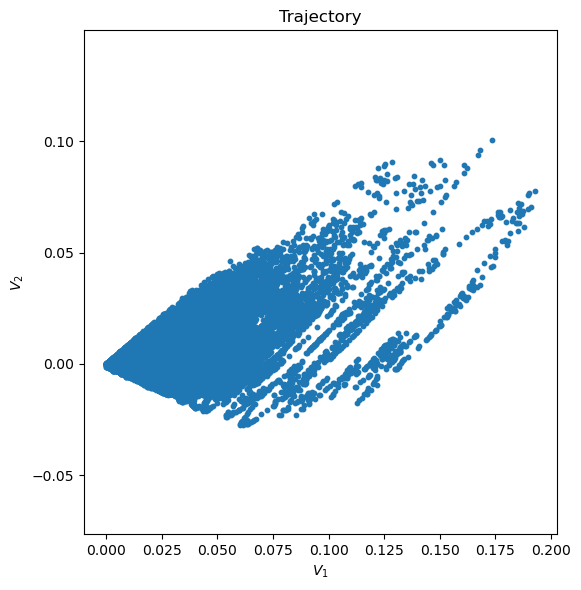

In [6]:
def plot_trajectory(trajectory, filename, point_size=10):
    """
    Trace une trajectoire 2D (shape: n x 2).

    Args:
        trajectory (np.ndarray): tableau (n, 2), trajectoire d'un processus.
        point_size (int): taille des points pour scatter.
    """
    if trajectory.shape[1] != 2:
        raise ValueError("La trajectoire doit avoir exactement 2 colonnes (2 dimensions).")

    plt.figure(figsize=(6, 6))
    plt.scatter(trajectory[:, 0], trajectory[:, 1], s=point_size)
    plt.xlabel(r"$V_1$")
    plt.ylabel(r"$V_2$")
    plt.title("Trajectory")
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_trajectory(V, "traj/traj_sqrt_2", point_size=10)


#### Domaine
$$Q = \begin{pmatrix}
q & -q \\
w_1 & w_2
\end{pmatrix}$$
$$\mathcal{D} = \left\{ \textbf{y} \in \mathbb{R}_+^2 \ \middle| \ \textbf{w}^{\top} \textbf{y} \geq 0, \ y_1 \geq y_2 \right\}$$

In [7]:
Q = np.array([[1, -1],
              [w[0], w[1]]])

#### Tracer les points finaux d'un grand nombre de trajectoires simulées

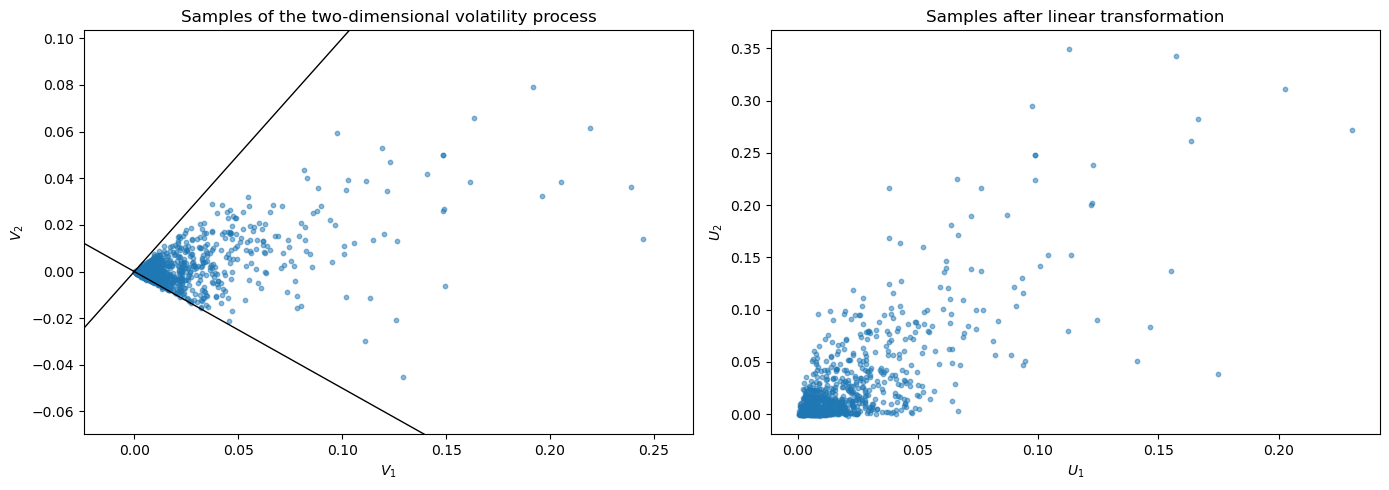

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_and_plot_final_samples(V_0, v0, b_func, sigma_func, x, w, N, n, T, num_simulations, Q, filename):
    """
    Simule plusieurs trajectoires avec simulate_batch et trace les nuages de points finaux
    dans l’espace original et après transformation linéaire Q.
    """

    # Simulation
    trajectories = simulate_batch(V_0, v0, b_func, sigma_func, x, w, N, n, T, num_simulations)

    # Points finaux
    results = trajectories[-1]  # shape: (num_simulations, N)
    transformed = results @ Q.T  # transformation linéaire

    # Définition des limites avec marge
    x_min, x_max = results[:, 0].min(), results[:, 0].max()
    y_min, y_max = results[:, 1].min(), results[:, 1].max()
    margin = 0.1 * max(x_max - x_min, y_max - y_min)
    x_plot_min = x_min - margin
    x_plot_max = x_max + margin
    y_plot_min = y_min - margin
    y_plot_max = y_max + margin

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Graphe original
    axes[0].scatter(results[:, 0], results[:, 1], s=10, alpha=0.5)

    x_vals = np.linspace(x_plot_min, x_plot_max, 300)
    axes[0].plot(x_vals, x_vals, 'k-', linewidth=1)  # y1 = y2
    slope = -(w[0] / w[1])
    y_vals = slope * x_vals
    axes[0].plot(x_vals, y_vals, 'k-', linewidth=1)  # w^T y = 0

    axes[0].set_xlim(x_plot_min, x_plot_max)
    axes[0].set_ylim(y_plot_min, y_plot_max)
    axes[0].set_xlabel(r"$V_1$")
    axes[0].set_ylabel(r"$V_2$")
    axes[0].set_title("Samples of the two-dimensional volatility process")

    # Graphe échantillons après transformation
    axes[1].scatter(transformed[:, 0], transformed[:, 1], s=10, alpha=0.5)
    axes[1].set_xlabel(r"$U_1$")
    axes[1].set_ylabel(r"$U_2$")
    axes[1].set_title("Samples after linear transformation")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

simulate_and_plot_final_samples(V_0, v0, b, sigma, x, w, N, n, T, 1000, Q, "terminal_points/terminal_points_sqrt_2")


#### Tracer tous les points des trajectoires d'un grand nombre de trajectoires simulées

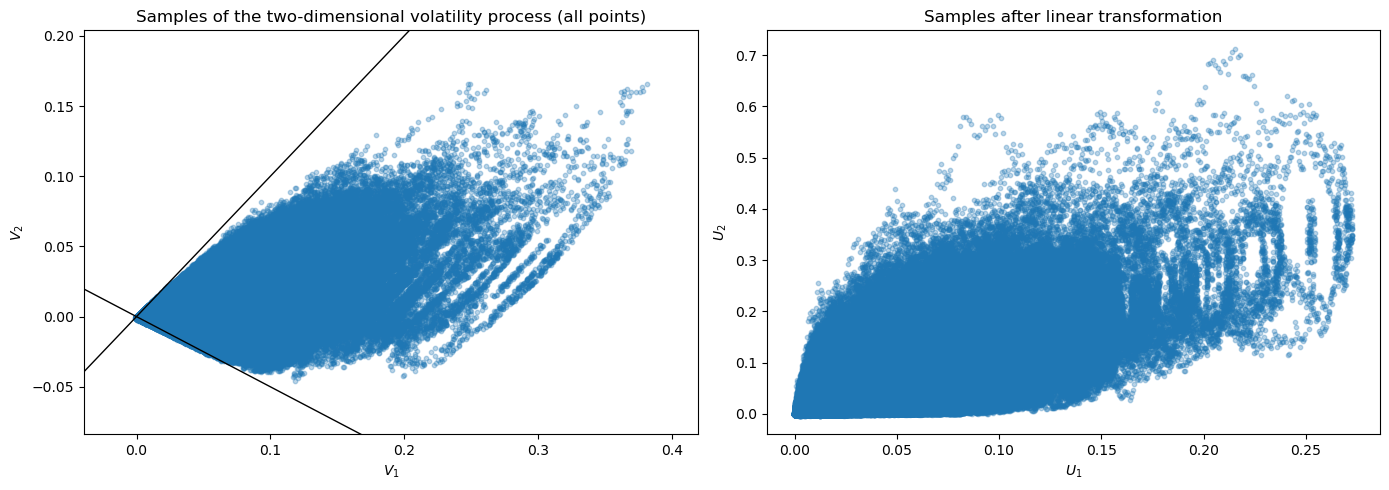

In [9]:
def simulate_and_plot_all_points(V_0, v0, b_func, sigma_func, x, w, N, n, T, num_simulations, Q, filename):
    """
    Simule plusieurs trajectoires avec simulate_batch, aplatit toutes les étapes,
    applique une transformation linéaire Q, et trace les points avant et après transformation.

    Args:
        V_0 (np.ndarray): condition initiale (N,)
        v0 (np.ndarray): condition initiale alternative (N,)
        b_func (callable): fonction dérive b(x)
        sigma_func (callable): fonction sigma(x)
        x (np.ndarray): paramètre x (N,)
        w (np.ndarray): vecteur w (N,)
        N (int): dimension
        n (int): nombre de pas de temps
        T (float): horizon final
        num_simulations (int): nombre de trajectoires simulées
        Q (np.ndarray): matrice de transformation (N, N)
    """

    trajectories = simulate_batch(V_0, v0, b_func, sigma_func, x, w, N, n, T, num_simulations)

    all_points = trajectories.reshape(-1, N)
    transformed = all_points @ Q.T

    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    margin = 0.1 * max(x_max - x_min, y_max - y_min)
    x_plot_min = x_min - margin
    x_plot_max = x_max + margin
    y_plot_min = y_min - margin
    y_plot_max = y_max + margin

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(all_points[:, 0], all_points[:, 1], s=10, alpha=0.3)

    x_vals = np.linspace(x_plot_min, x_plot_max, 300)
    axes[0].plot(x_vals, x_vals, 'k-', linewidth=1)  # y1 = y2
    slope = -(w[0] / w[1])
    y_vals = slope * x_vals
    axes[0].plot(x_vals, y_vals, 'k-', linewidth=1)  # w^T y = 0

    axes[0].set_xlim(x_plot_min, x_plot_max)
    axes[0].set_ylim(y_plot_min, y_plot_max)
    axes[0].set_xlabel(r"$V_1$")
    axes[0].set_ylabel(r"$V_2$")
    axes[0].set_title("Samples of the two-dimensional volatility process (all points)")

    axes[1].scatter(transformed[:, 0], transformed[:, 1], s=10, alpha=0.3)
    axes[1].set_xlabel(r"$U_1$")
    axes[1].set_ylabel(r"$U_2$")
    axes[1].set_title("Samples after linear transformation")

    plt.savefig(filename)
    plt.tight_layout()
    plt.show()

simulate_and_plot_all_points(V_0, v0, b, sigma, x, w, N, n, T, 30, Q, "trajs/trajs_sqrt_2") 

### Cas $N=3$

$$Q = \begin{pmatrix}
w_1 & -w_1 & 0 \\
w_1 & w_2 & -w_1 - w_2 \\
w_1 & w_2 & w_3
\end{pmatrix}$$

In [10]:
N = 3
x3 = np.array([1, 5, 25])
w3 = np.array([1, 2, 3])
lam = 0.3
nu = 0.3
V0 = 0.02
theta = 0.02
T = 100
v0 = V0 / (2 * (w3[0]/x3[0] + w3[1]/x3[1]) + w3[2]/x3[2]) * (1/x3)
n = 10**5
V_0 = v0

In [11]:
Q3 = np.array([
    [ w3[0],     -w3[0],            0        ],
    [ w3[0],      w3[1],    -w3[0] - w3[1]      ],
    [ w3[0],      w3[1],     w3[2]            ]
])

#### Tracer une trajectoire

In [12]:
trajectories = simulate_batch(V_0, v0, b, sigma, x3, w3, N, n, T, 1)
trajectory = trajectories[:, 0, :]

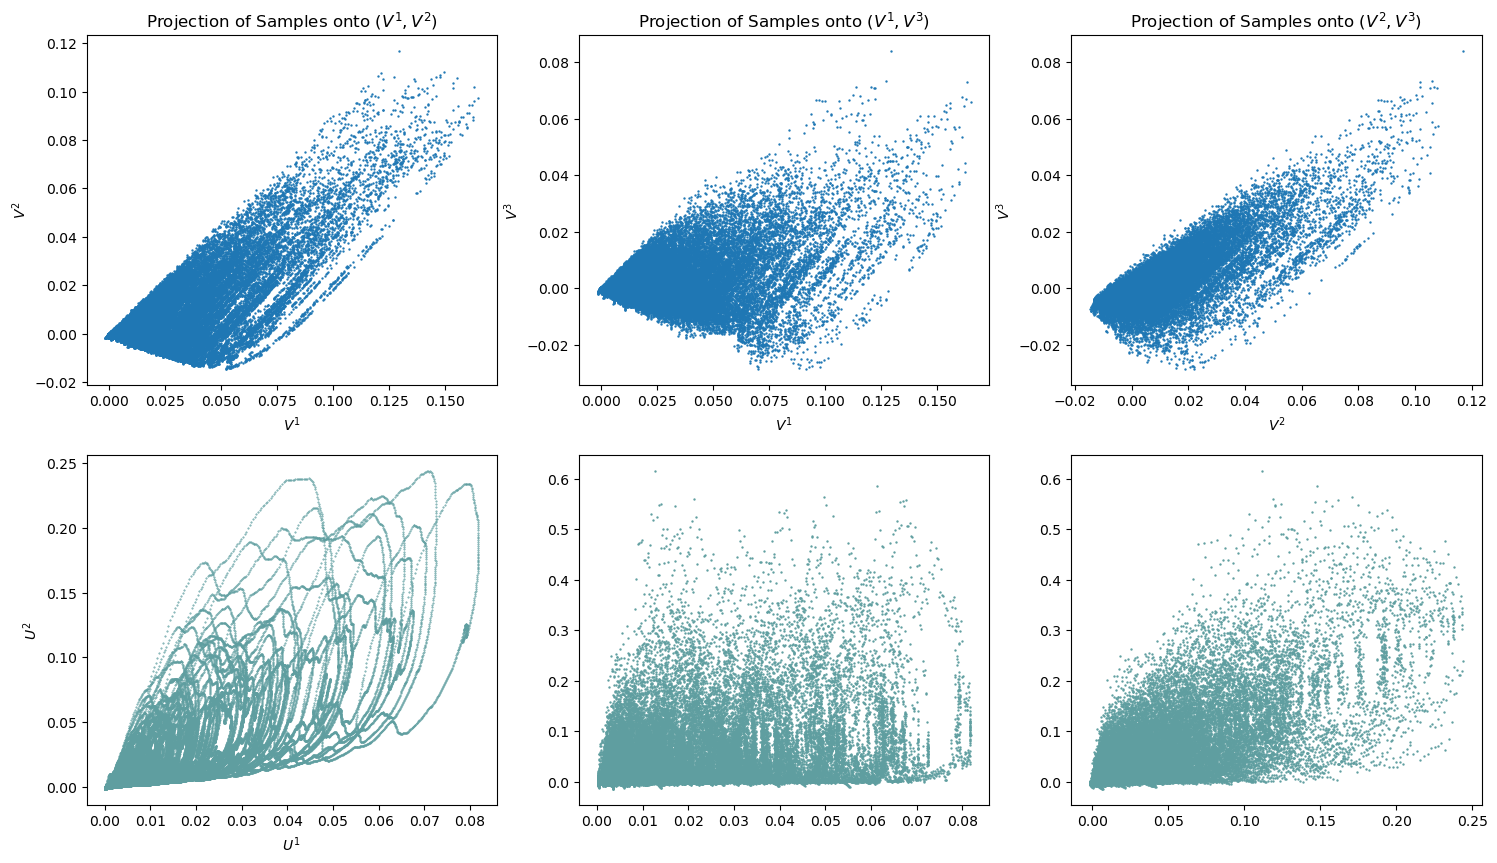

In [13]:
# Extraire la trajectoire proprement (forme : (T+1, 3))
trajectory = np.squeeze(trajectories[:, 0, :])

# Appliquer Q à chaque vecteur V_t → U = QV
U = trajectory @ Q3.T  # (T+1, 3)

v1 = trajectory[:, 0]
v2 = trajectory[:, 1]
v3 = trajectory[:, 2]

u1 = U[:, 0]
u2 = U[:, 1]
u3 = U[:, 2]

# Subplots : 2 lignes, 3 colonnes
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Ligne 1 : projections originales
axs[0, 0].scatter(v1, v2, s=0.5)
axs[0, 1].scatter(v1, v3, s=0.5)
axs[0, 2].scatter(v2, v3, s=0.5)

axs[0, 0].set_xlabel('$V^1$'); axs[0, 0].set_ylabel('$V^2$')
axs[0, 1].set_xlabel('$V^1$'); axs[0, 1].set_ylabel('$V^3$')
axs[0, 2].set_xlabel('$V^2$'); axs[0, 2].set_ylabel('$V^3$')

axs[0, 0].set_title('Projection of Samples onto $(V^1, V^2)$')
axs[0, 1].set_title('Projection of Samples onto $(V^1, V^3)$')
axs[0, 2].set_title('Projection of Samples onto $(V^2, V^3)$')

# Ligne 2 : projections après transformation (U)
axs[1, 0].scatter(u1, u2, s=0.2, color='cadetblue')
axs[1, 1].scatter(u1, u3, s=0.5, color='cadetblue')
axs[1, 2].scatter(u2, u3, s=0.5, color='cadetblue')

axs[1, 0].set_xlabel('$U^1$'); axs[1, 0].set_ylabel('$U^2$')
axs[1, 1].set

plt.savefig("trajs/trajs_3")


#### Tracer les points finaux d'un grand nombre de trajectoires simulées

In [14]:
num_simulations = 1000

# Simulation
trajectories = simulate_batch(V_0, v0, b, sigma, x3, w3, N, n, T, num_simulations)

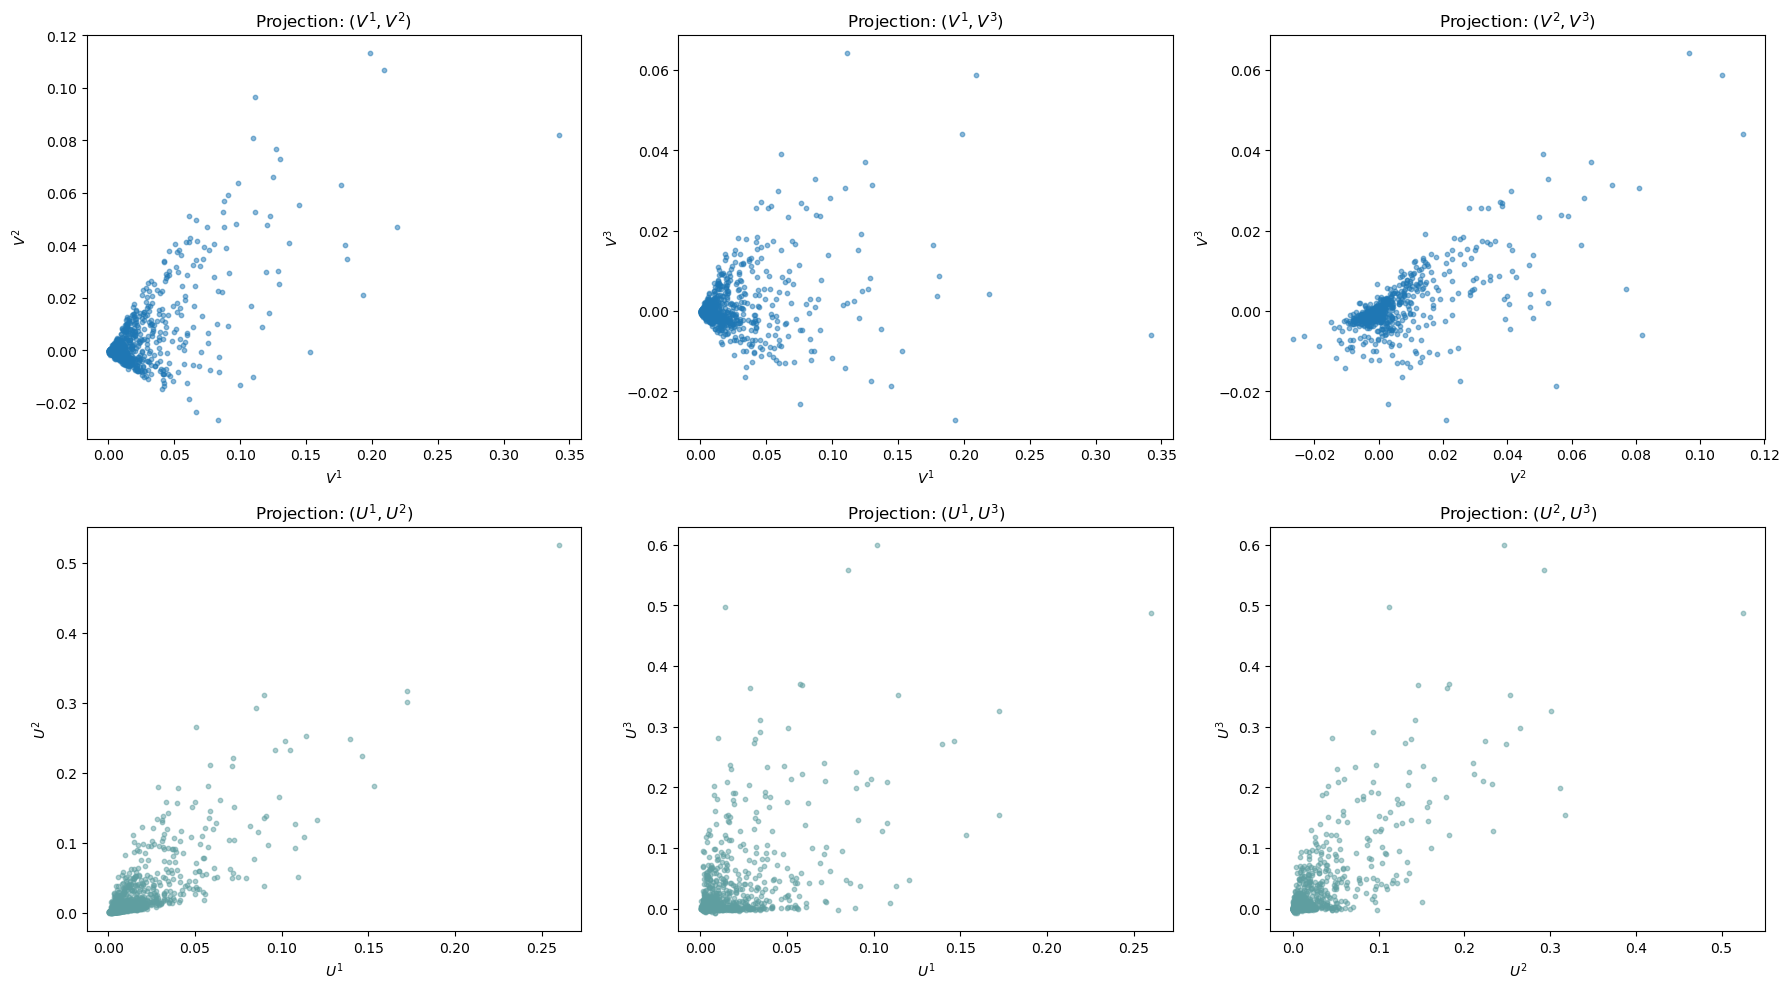

In [ ]:
import matplotlib.pyplot as plt

# Extraire les points finaux
results = trajectories[-1]  # shape: (num_simulations, 3)
U = results @ Q3.T  # shape: (num_simulations, 3)

# Préparer les combinaisons pour les projections
projections = [(0, 1), (0, 2), (1, 2)]

# Créer une seule figure avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Ligne 1 : projections dans l’espace original (V)
for idx, (i, j) in enumerate(projections):
    ax = axes[0, idx]
    ax.scatter(results[:, i], results[:, j], s=10, alpha=0.5)
    ax.set_xlabel(f"$V^{i+1}$")
    ax.set_ylabel(f"$V^{j+1}$")
    ax.set_title(f"Projection: $(V^{i+1}, V^{j+1})$")

# Ligne 2 : projections dans l’espace transformé (U)
for idx, (i, j) in enumerate(projections):
    ax = axes[1, idx]
    ax.scatter(U[:, i], U[:, j], s=10, alpha=0.5, color='cadetblue')
    ax.set_xlabel(f"$U^{i+1}$")
    ax.set_ylabel(f"$U^{j+1}$")
    ax.set_title(f"Projection: $(U^{i+1}, U^{j+1})$")

plt.tight_layout()
plt.savefig("terminal_points/terminal_points_sqrt_3")
plt.show()

# Modèle $b$ tangente hyperbolique et $\sigma$ sigmoïde

$$b(z) = \theta (\nu - z) \tanh (\beta z), \ \ \sigma (z) = \frac{\alpha z}{1+ \gamma |z|}$$

In [16]:
nu = 1
theta = 0.5
beta = 1.5
alpha=0.3
gamma = 1

def b(z):
    return theta*(nu-z)*np.tanh(beta*z)

def sigma(z):
    return alpha*z/(1+gamma*np.abs(z))

v0 = 0.01*(1/x)
V_0 = np.array([0,0])

N=2

In [17]:
trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, 1)
V = trajectories[:, 0, :]

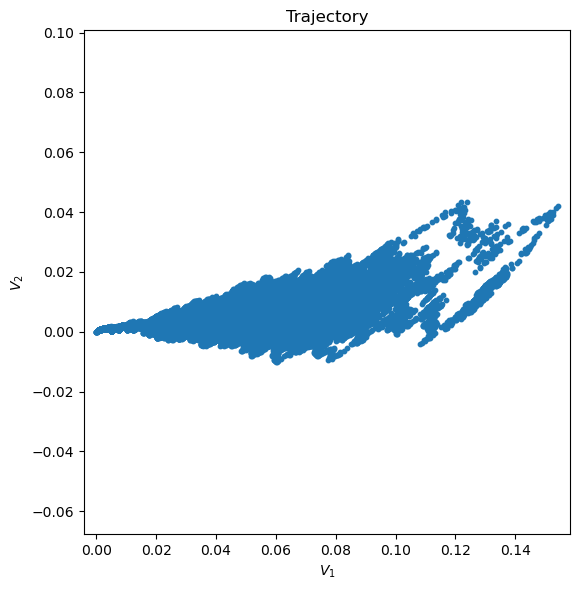

In [18]:
plot_trajectory(V, "traj/traj_tanh", point_size=10)

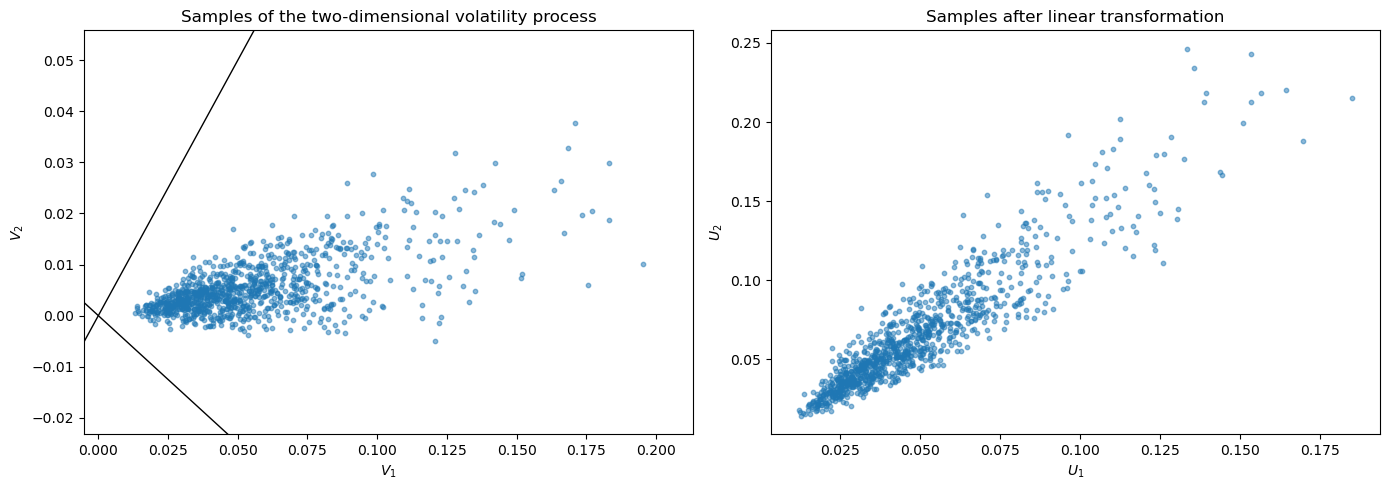

In [19]:
simulate_and_plot_final_samples(V_0, v0, b, sigma, x, w, N, n, T, 1000, Q, "terminal_points/terminal_points_tanh")


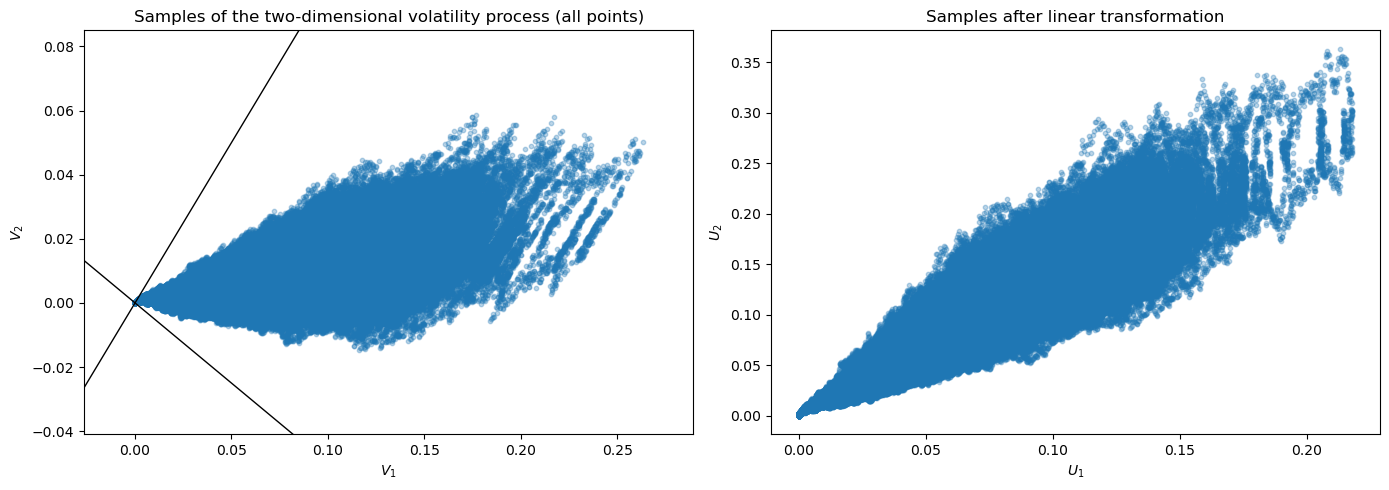

In [20]:
simulate_and_plot_all_points(V_0, v0, b, sigma, x, w, N, n, T, 30, Q, "trajs/trajs_tanh") 

# Black-Scholes

$$b(z) = \mu z, \ \ \sigma (z) = \sigma z$$

In [21]:
vol = 0.1
mu = 0.08

def b(z):
    return mu*z

def sigma(z):
    return vol*z

v0 = 0.001*(1/x)
V_0 = np.array([0,0])

In [22]:
trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, 1)
V = trajectories[:, 0, :]

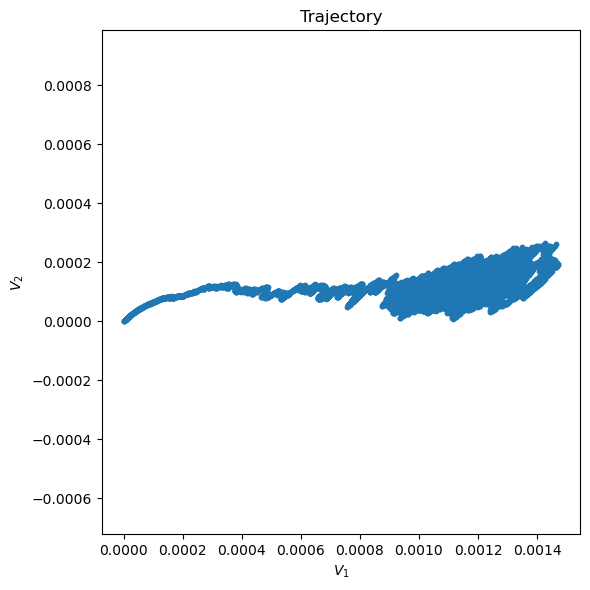

In [23]:
plot_trajectory(V, "traj/traj_bs", point_size=10)

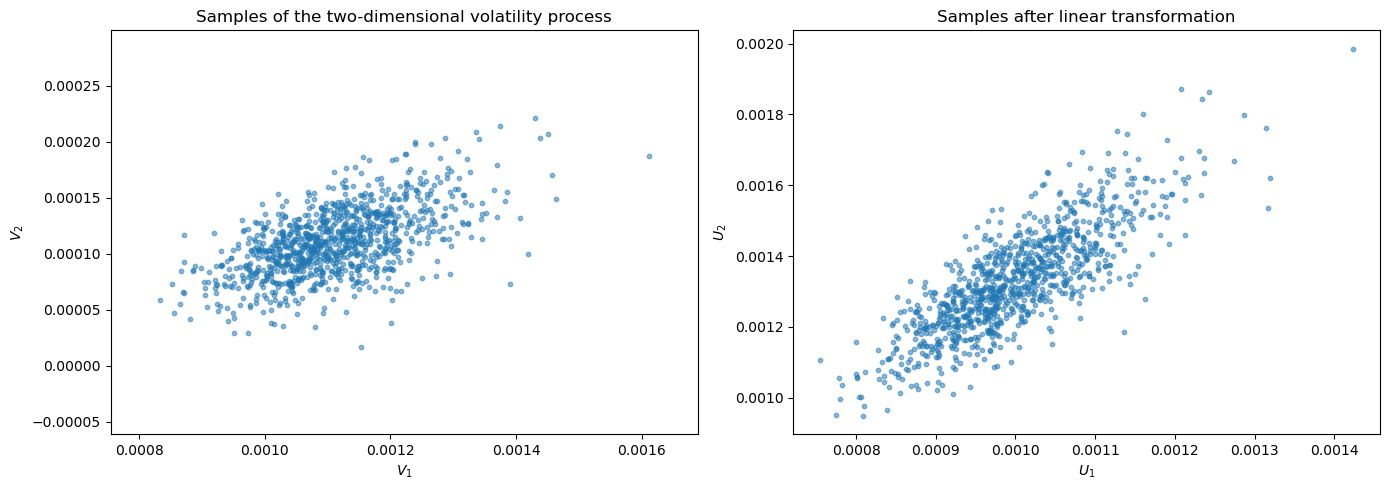

In [24]:
simulate_and_plot_final_samples(V_0, v0, b, sigma, x, w, N, n, T, 1000, Q, "terminal_points/terminal_points_bs")

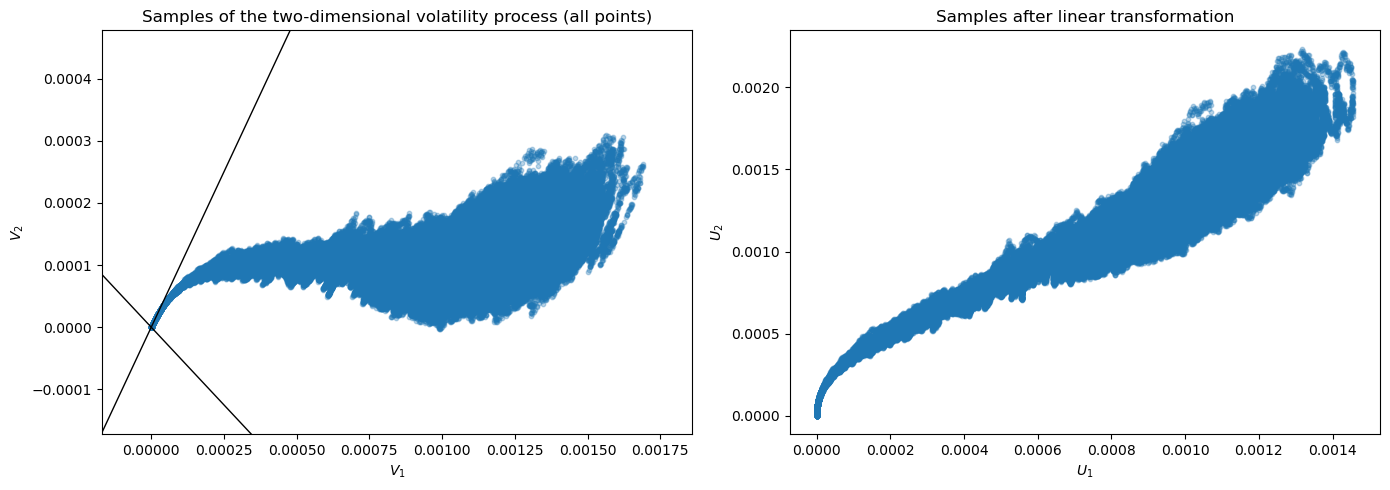

In [25]:
simulate_and_plot_all_points(V_0, v0, b, sigma, x, w, N, n, T, 30, Q, "trajs/trajs_bs") 

# Modèle $\sigma$ fonction puissance $\eta$

$$b(x) = \theta - \lambda x, \quad \sigma(x) = \nu x^{\eta}$$

In [26]:
lam = 0.3
nu = 0.3
theta = 0.02

def b(z):
    return theta - lam * z

# Liste des eta et des fonctions sigma correspondantes
eta_values = [0.6, 0.75, 0.9, 0.95]

# Créer les fonctions sigma pour chaque eta
sigma_functions = []
for eta in eta_values:
    sigma_functions.append(lambda z, eta=eta: nu * (np.maximum(z, 0))**eta)

In [27]:
v0 = 0.01*(1/x)
V_0 = np.array([0,0])

eta= 0.6


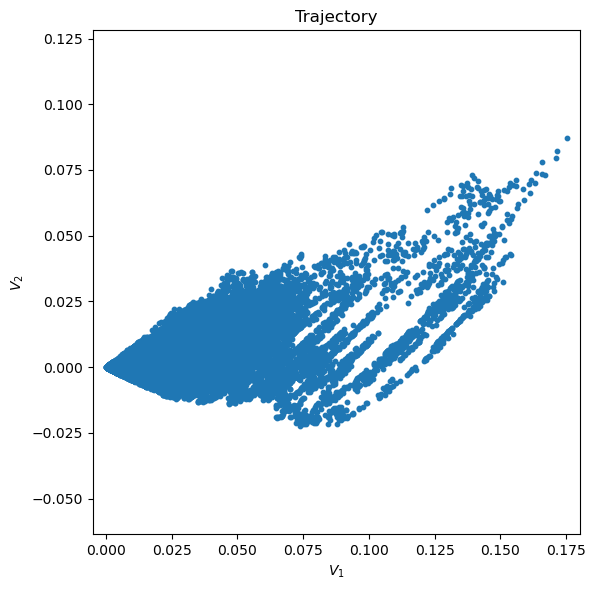

eta= 0.75


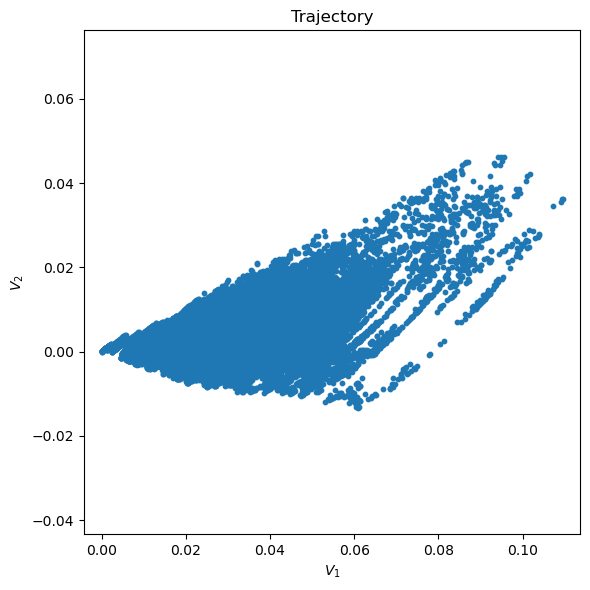

eta= 0.9


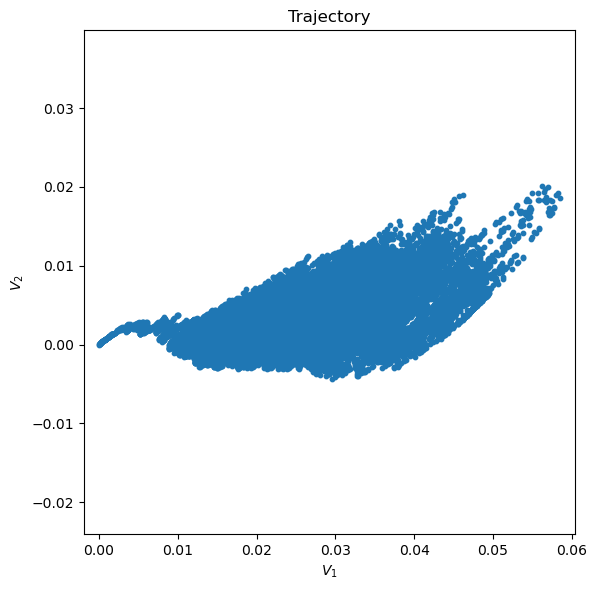

eta= 0.95


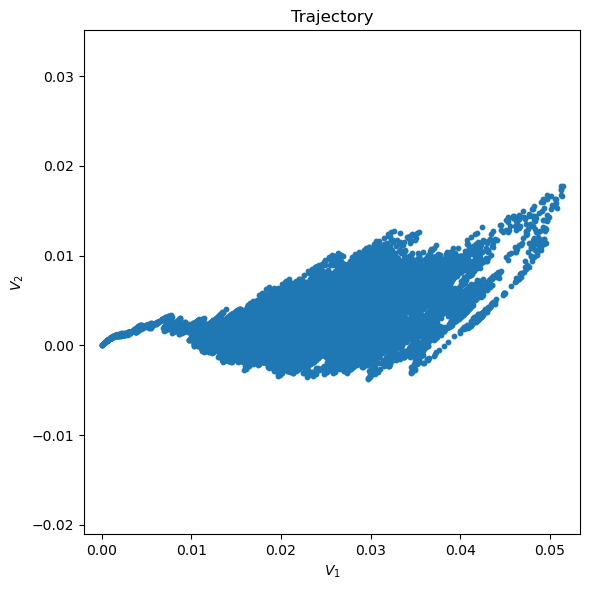

In [28]:
# Boucle de simulation et d'affichage
for eta, sigma in zip(eta_values, sigma_functions):
    trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, 1)
    V = trajectories[:, 0, :]
    print("eta=", eta)
    plot_trajectory(V, "traj/traj_eta_"+str(int(eta*100)), point_size=10)

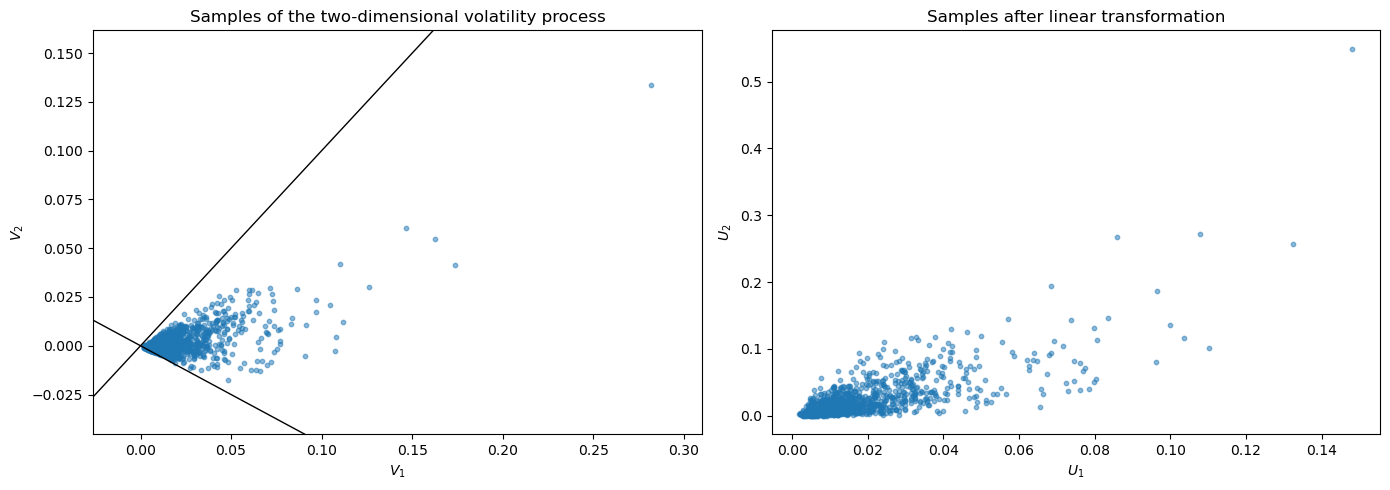

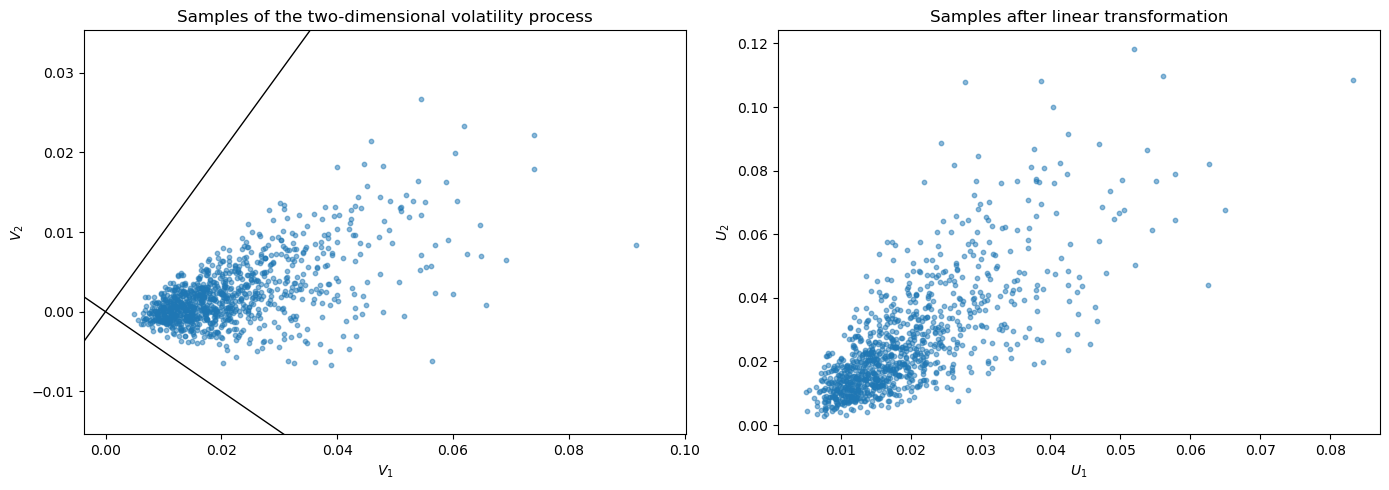

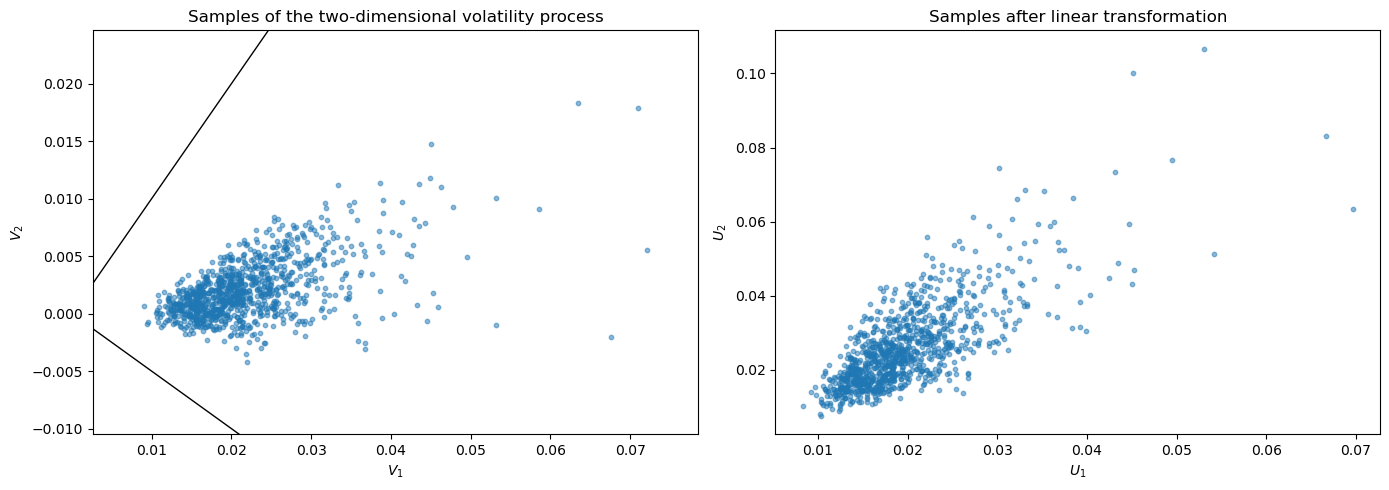

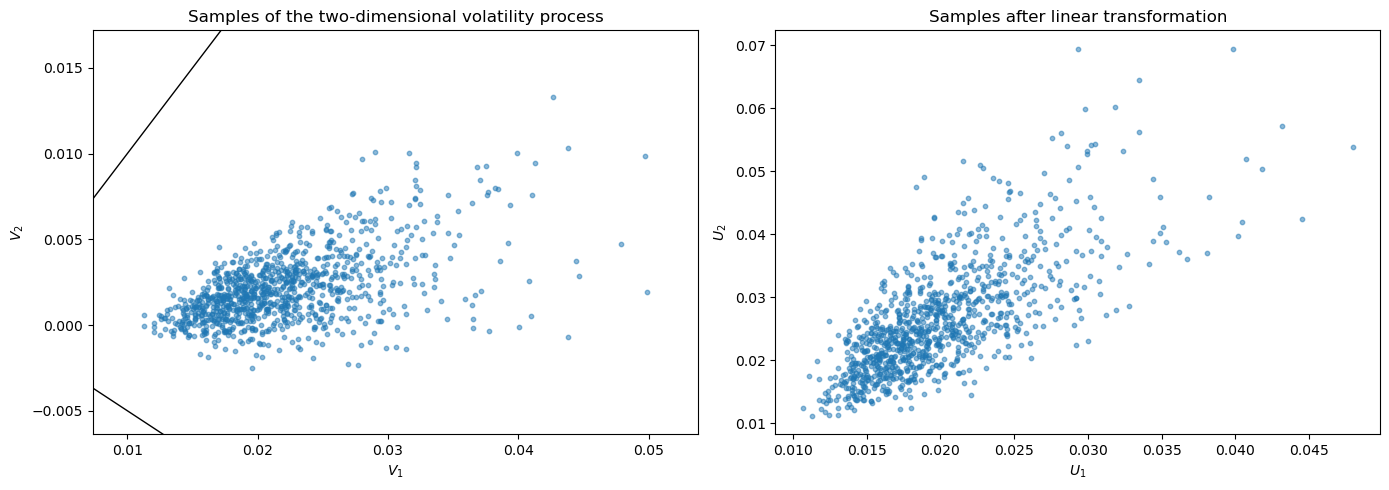

In [29]:
for eta, sigma in zip(eta_values, sigma_functions):
    simulate_and_plot_final_samples(V_0, v0, b, sigma, x, w, N, n, T, 1000, Q, "terminal_points/terminal_points_eta_"+str(int(eta*100)))

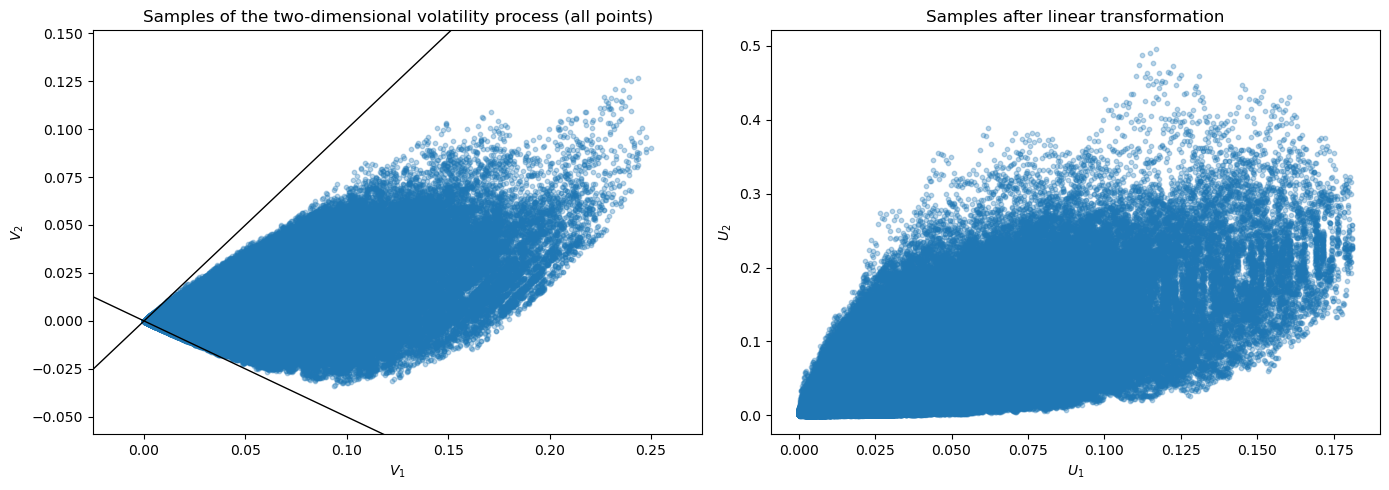

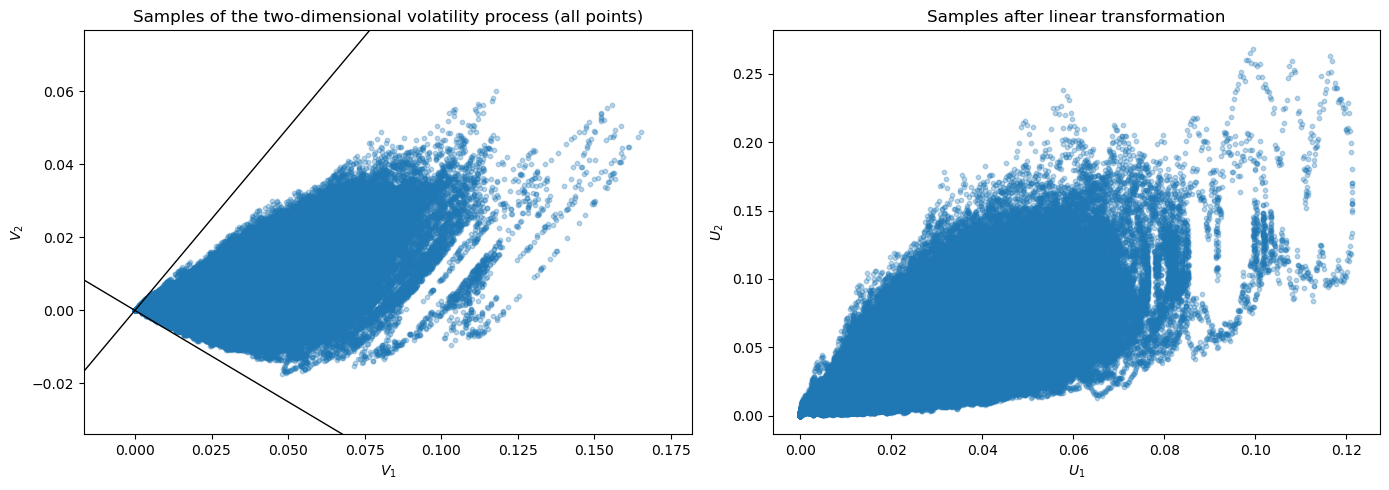

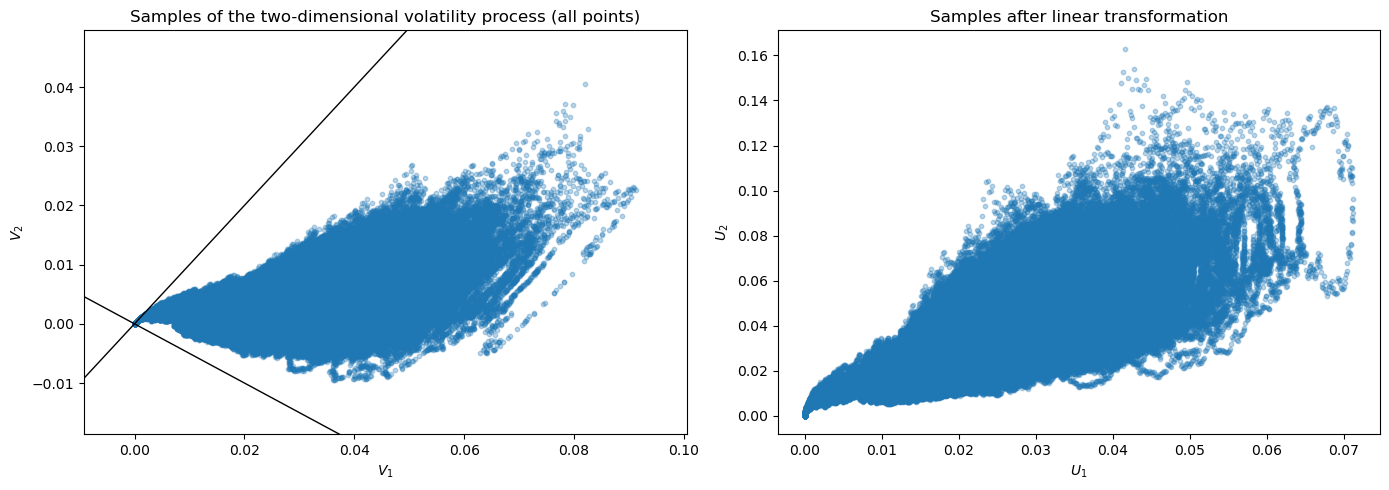

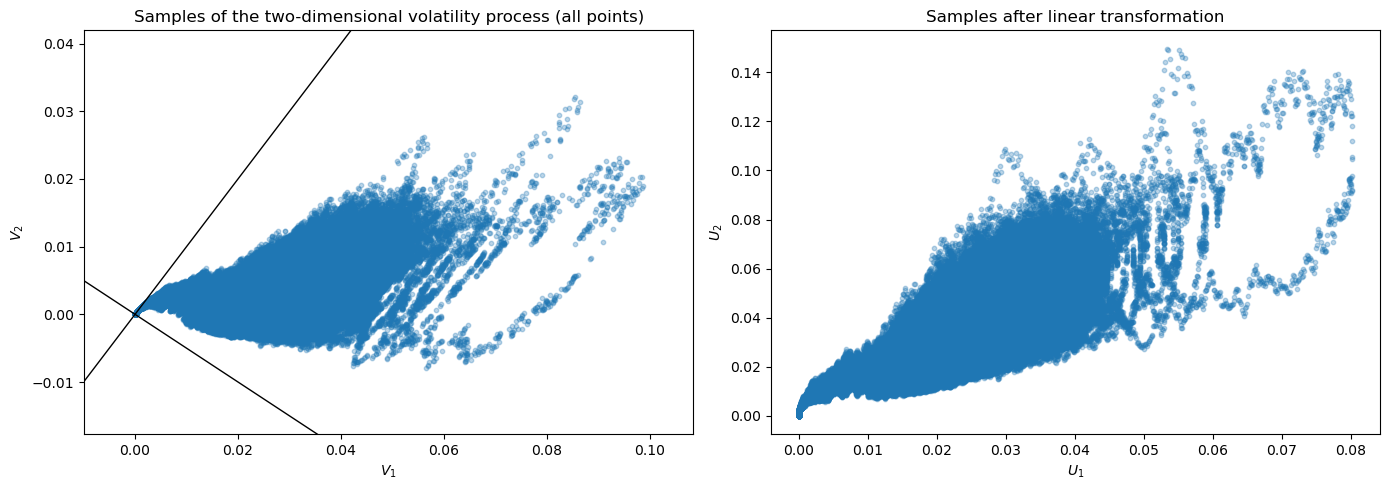

In [30]:
for eta, sigma in zip(eta_values, sigma_functions):
    simulate_and_plot_all_points(V_0, v0, b, sigma, x, w, N, n, T, 30, Q, "trajs/trajs_eta_"+str(int(eta*100)))

# Comparaison avec et sans schéma

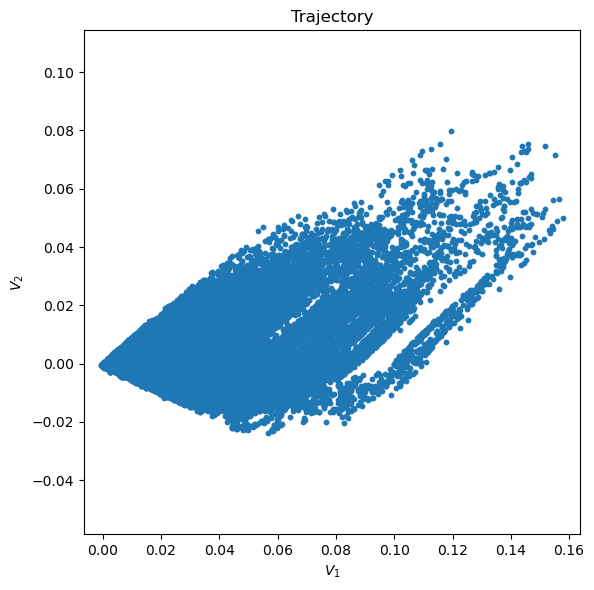

In [13]:
N = 2
x = np.array([1, 10])
w = np.array([1, 2])
lam = 0.3
nu = 0.3
V0 = 0.02
theta = 0.02
T = 100
v0 = np.array([0,0])
n = 10**5
V_0 = np.array([0,0])

def b(x):
    return theta - lam * x

def sigma(x):
    return nu * np.sqrt(np.maximum(x, 0))

trajectories = simulate_batch(V_0, v0, b, sigma, x, w, N, n, T, 1)
V = trajectories[:, 0, :]

def plot_trajectory(trajectory, filename, point_size=10):
    """
    Trace une trajectoire 2D (shape: n x 2).

    Args:
        trajectory (np.ndarray): tableau (n, 2), trajectoire d'un processus.
        point_size (int): taille des points pour scatter.
    """
    if trajectory.shape[1] != 2:
        raise ValueError("La trajectoire doit avoir exactement 2 colonnes (2 dimensions).")

    plt.figure(figsize=(6, 6))
    plt.scatter(trajectory[:, 0], trajectory[:, 1], s=point_size)
    plt.xlabel(r"$V_1$")
    plt.ylabel(r"$V_2$")
    plt.title("Trajectory")
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_trajectory(V, "traj/traj_sqrt_2", point_size=10)
